In [1]:
import cell2location as c2l
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import scanpy as sc
import pandas as pd
import numpy as np
import scvi
import anndata as ad
import os
import json
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scikit_posthocs import posthoc_dunn
from kneed import KneeLocator
from collections import defaultdict
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests
import ace_tools_open as tools
from tqdm import tqdm

In [2]:
file_path = '/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/GSE234713_CosMx_annotated.h5ad'
adata = sc.read_h5ad(file_path)
adata

AnnData object with n_obs × n_vars = 459095 × 980
    obs: 'cell_id', 'fov', 'patient', 'subset', 'unique_cell_id'

In [3]:
# Load the AnnData object
adata = sc.read_h5ad('/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/GSE234713_CosMx_annotated.h5ad')

# Print the first 5 rows of the observation annotations (.obs)
print("Observation (cell) annotations:")
print(adata.obs.head())

# Print the first 5 rows of the variable annotations (.var)
print("\nVariable (gene) annotations:")
print(adata.var.head())

Observation (cell) annotations:
  cell_id fov patient subset unique_cell_id
0       1   1    CD c              CD c_1_1
1       2   1    CD c              CD c_1_2
2       3   1    CD c              CD c_1_3
3       4   1    CD c              CD c_1_4
4       5   1    CD c              CD c_1_5

Variable (gene) annotations:
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]


In [5]:
unique_fov = adata.obs['fov'].unique()
unique_patient = adata.obs['patient'].unique()
unique_subset = adata.obs['subset'].unique()

# Print the unique values
print("Unique values for 'fov':")
print(unique_fov)

print("\nUnique values for 'patient':")
print(unique_patient)

print("\nUnique values for 'subset':")
print(unique_subset)

Unique values for 'fov':
['1', '2', '3', '4', '5', ..., '20', '21', '22', '23', '24']
Length: 24
Categories (24, object): ['1', '2', '3', '4', ..., '21', '22', '23', '24']

Unique values for 'patient':
['CD c', 'CD b', 'CD a', 'HC c', 'HC b', 'HC a', 'UC a', 'UC b', 'UC c']
Categories (9, object): ['CD a', 'CD b', 'CD c', 'HC a', ..., 'HC c', 'UC a', 'UC b', 'UC c']

Unique values for 'subset':
['']


In [6]:
# File paths
abundance_file = '/blue/pbenos/tan.m/IBDCosMx_scRNAseq/Outputs_3000epochs_500samples_NMF-k6/inferred_cell_type_abundances.csv'
h5ad_file = '/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/GSE234713_CosMx_annotated.h5ad'

# Load the abundance data
cell_type_abundances = pd.read_csv(abundance_file, index_col='unique_cell_id')

# Find the column with the maximum value for each row (cell) to determine the predicted cell type
predicted_cell_types = cell_type_abundances.idxmax(axis=1)

# Load the AnnData object
adata = ad.read_h5ad(h5ad_file)

# Align the predicted cell types with the AnnData object's unique_cell_id
# It's important to ensure the indices match correctly.
adata.obs['PredictedCellType'] = predicted_cell_types.loc[adata.obs['unique_cell_id']].values

# You can save the updated AnnData object if you wish
# adata.write_h5ad(h5ad_file)

# Verify the assignment by printing the first few rows of the updated .obs dataframe
print(adata.obs[['unique_cell_id', 'PredictedCellType']].head())

  unique_cell_id PredictedCellType
0       CD c_1_1                N2
1       CD c_1_2                NK
2       CD c_1_3        MT T cells
3       CD c_1_4       Eosinophils
4       CD c_1_5   Cycling T cells


In [7]:
# Use .value_counts() to get a count for each unique cell type
predicted_cell_type_counts = adata.obs['PredictedCellType'].value_counts()

# Print the resulting counts
print("Counts of each unique PredictedCellType:")
print(predicted_cell_type_counts)

Counts of each unique PredictedCellType:
PredictedCellType
Cycling T cells                 66679
Ribhi T cells                   54384
M0                              31395
MT T cells                      24566
Tuft cells                      22960
PC IgG                          18387
N2                              18376
Secretory progenitor            16187
Epithelium Ribhi                14554
N1                              12175
Mast                            10613
M2                               9980
Colonocytes                      8790
Cycling TA                       8770
Myofibroblasts                   8583
Inflammatory fibroblasts         7778
Endothelium                      7682
N3                               7254
Eosinophils                      6607
CD4                              6417
B cell                           6377
Goblet                           6352
Paneth-like                      6150
Glia                             6139
T cells CCL20                

In [8]:
num_unique_cell_types = adata.obs['PredictedCellType'].nunique()

# Print the result
print(f"The total number of unique PredictedCellTypes is: {num_unique_cell_types}")

The total number of unique PredictedCellTypes is: 54


In [9]:
# Define file paths
h5ad_file = '/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/GSE234713_CosMx_annotated.h5ad'
abundance_file = '/blue/pbenos/tan.m/IBDCosMx_scRNAseq/Outputs_3000epochs_500samples_NMF-k6/inferred_cell_type_abundances.csv'
output_h5ad_file = '/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/GSE234713_CosMx_annotated_with_predicted_cell_type.h5ad'

# Load the AnnData object
adata = sc.read_h5ad(h5ad_file)

# Load the cell type abundance data from the CSV file
cell_type_abundances = pd.read_csv(abundance_file, index_col='unique_cell_id')

# Find the predicted cell type for each cell by taking the column with the max abundance
predicted_cell_types = cell_type_abundances.idxmax(axis=1)

# Assign the 'PredictedCellType' column to the adata.obs DataFrame
adata.obs['PredictedCellType'] = predicted_cell_types.loc[adata.obs['unique_cell_id']].values

# Save the updated AnnData object to a new file
adata.write_h5ad(output_h5ad_file)

print(f"AnnData object with 'PredictedCellType' saved to: {output_h5ad_file}")

AnnData object with 'PredictedCellType' saved to: /blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/GSE234713_CosMx_annotated_with_predicted_cell_type.h5ad


In [10]:
# Define the file path
file_path = '/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/GSE234713_CosMx_annotated_with_predicted_cell_type.h5ad'


# Load the AnnData object from the file
adata = sc.read_h5ad(file_path)

# Print the first 5 rows of the observation annotations (.obs),
# which now includes the 'PredictedCellType' column.
print("Head of the .obs dataframe (cell annotations):")
print(adata.obs.head())

# You can also check the head of the variable annotations (.var)
# to ensure the file loaded correctly.
print("\nHead of the .var dataframe (gene annotations):")
print(adata.var.head())

Head of the .obs dataframe (cell annotations):
  cell_id fov patient subset unique_cell_id PredictedCellType
0       1   1    CD c              CD c_1_1                N2
1       2   1    CD c              CD c_1_2                NK
2       3   1    CD c              CD c_1_3        MT T cells
3       4   1    CD c              CD c_1_4       Eosinophils
4       5   1    CD c              CD c_1_5   Cycling T cells

Head of the .var dataframe (gene annotations):
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]


In [11]:
# Define file paths
h5ad_file = '/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/GSE234713_CosMx_annotated.h5ad'
w_matrix_file = '/blue/pbenos/tan.m/IBDCosMx_scRNAseq/Outputs_3000epochs_500samples_NMF-k6/NMF_W_matrix.npy'

# Load the AnnData object
try:
    adata = sc.read_h5ad(h5ad_file)
except FileNotFoundError:
    print(f"Error: The file at {h5ad_file} was not found.")
    exit()

# Load the NMF W matrix
try:
    w_matrix = np.load(w_matrix_file)
except FileNotFoundError:
    print(f"Error: The file at {w_matrix_file} was not found.")
    exit()

# Find the index of the maximum value for each row (cell)
# This index corresponds to the dominant NMF factor for that cell
nmf_factors = np.argmax(w_matrix, axis=1)

# Assign the NMF factors to a new column in the observation dataframe
# This assumes the order of cells in the W matrix is the same as in the AnnData object.
# A more robust approach would involve matching a cell identifier, but we are
# assuming a consistent order here based on the problem description.
adata.obs['NMF_factor'] = nmf_factors

# Print the head of the .obs dataframe to verify the new column
print("Head of the .obs dataframe with the new 'NMF_factor' column:")
print(adata.obs[['unique_cell_id', 'NMF_factor']].head())

# Optional: Save the updated AnnData object to a new file
# new_h5ad_file = 'GSE234713_CosMx_annotated_with_nmf_factor.h5ad'
# adata.write_h5ad(new_h5ad_file)
# print(f"\nUpdated AnnData object saved to: {new_h5ad_file}")

Head of the .obs dataframe with the new 'NMF_factor' column:
  unique_cell_id  NMF_factor
0       CD c_1_1           5
1       CD c_1_2           4
2       CD c_1_3           5
3       CD c_1_4           5
4       CD c_1_5           5


In [12]:
# List the unique values of 'NMF_factor'
unique_nmf_factors = adata.obs['NMF_factor'].unique()

print(unique_nmf_factors)

[5 4 3 2]


In [13]:
# Define file paths
h5ad_input_file = '/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/GSE234713_CosMx_annotated_with_predicted_cell_type.h5ad'
w_matrix_file = '/blue/pbenos/tan.m/IBDCosMx_scRNAseq/Outputs_3000epochs_500samples_NMF-k6/NMF_W_matrix.npy'
output_h5ad_file = '/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/GSE234713_CosMx_annotated_with_celltype_and_nmf_factor.h5ad'

# Load the AnnData object which already contains PredictedCellType
adata = sc.read_h5ad(h5ad_input_file)

# Load the NMF W matrix
w_matrix = np.load(w_matrix_file)

# Assign and re-index NMF_factor
# Find the dominant NMF factor for each cell
nmf_factors = np.argmax(w_matrix, axis=1)

# Assign the factors to a new column
# This assumes the order of cells in the W matrix matches the AnnData object
adata.obs['NMF_factor'] = nmf_factors

# Define the re-indexing map
factor_mapping = {2: 1, 3: 2, 4: 3, 5: 4}

# Re-index the NMF factors
adata.obs['NMF_factor'].replace(factor_mapping, inplace=True)

# Save the final, updated AnnData object
adata.write_h5ad(output_h5ad_file)

print(f"Updated AnnData object saved to: {output_h5ad_file}")

/scratch/local/10013196/ipykernel_1976361/155365410.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  adata.obs['NMF_factor'].replace(factor_mapping, inplace=True)


Updated AnnData object saved to: /blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/GSE234713_CosMx_annotated_with_celltype_and_nmf_factor.h5ad


In [14]:
# Define the file path
file_path = '/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/GSE234713_CosMx_annotated_with_celltype_and_nmf_factor.h5ad'

# Load the AnnData object from the file
try:
    adata = sc.read_h5ad(file_path)

    # Print the first 5 rows of the observation annotations (.obs)
    print("Head of the .obs dataframe (cell annotations):")
    print(adata.obs.head())

    # Print the first 5 rows of the variable annotations (.var)
    print("\nHead of the .var dataframe (gene annotations):")
    print(adata.var.head())

except FileNotFoundError:
    print(f"Error: The file at {file_path} was not found. Please verify the file path.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Head of the .obs dataframe (cell annotations):
  cell_id fov patient subset unique_cell_id PredictedCellType  NMF_factor
0       1   1    CD c              CD c_1_1                N2           4
1       2   1    CD c              CD c_1_2                NK           3
2       3   1    CD c              CD c_1_3        MT T cells           4
3       4   1    CD c              CD c_1_4       Eosinophils           4
4       5   1    CD c              CD c_1_5   Cycling T cells           4

Head of the .var dataframe (gene annotations):
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]


In [16]:
# Get the unique values from the 'NMF_factor' column
unique_nmf_factors = adata.obs['NMF_factor'].unique()

# Print the unique values
print("Unique values of 'NMF_factor':")
print(unique_nmf_factors)

Unique values of 'NMF_factor':
[4 3 2 1]


Stacked bar graph with ordered bars saved to: /blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Analysis/nmf_factor_distribution_stacked


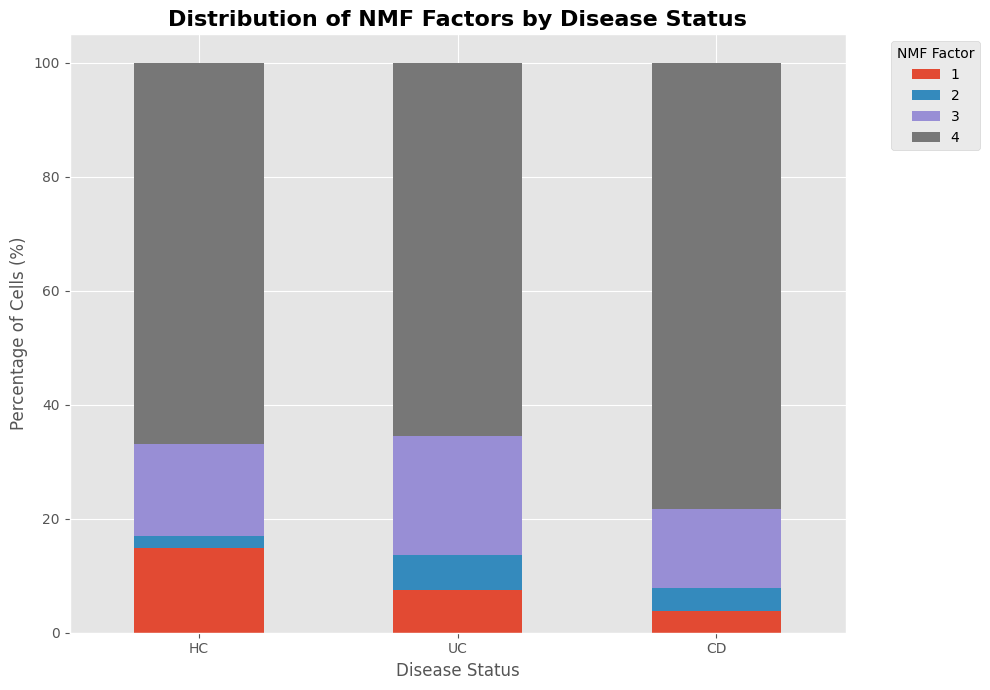

In [27]:
# 1. Extract disease status from the 'unique_cell_id' column
adata.obs['disease_status'] = adata.obs['unique_cell_id'].str.split(' ', n=1, expand=True)[0]

# 2. Create a crosstab to count cells for each NMF factor within each disease status
stacked_data = pd.crosstab(adata.obs['disease_status'], adata.obs['NMF_factor'])

# 3. Normalize the data to get percentages
stacked_data_percent = stacked_data.div(stacked_data.sum(axis=1), axis=0) * 100

# 4. Re-index the DataFrame to set the desired bar order
desired_order = ['HC', 'UC', 'CD']
stacked_data_percent = stacked_data_percent.reindex(desired_order)

# 5. Create the stacked bar graph
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7))

stacked_data_percent.plot(kind='bar', stacked=True, ax=ax, rot=0)

# Set plot titles and labels
ax.set_title('Distribution of NMF Factors by Disease Status', fontsize=16, fontweight='bold')
ax.set_xlabel('Disease Status', fontsize=12)
ax.set_ylabel('Percentage of Cells (%)', fontsize=12)
ax.legend(title='NMF Factor', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to make sure labels and legend are not cut off
fig.tight_layout()

# 6. Save the plot
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

output_path = "/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Analysis/nmf_factor_distribution_stacked"
plt.savefig(output_path, dpi=600)

print(f"Stacked bar graph with ordered bars saved to: {output_path}")

Bar graph of NMF factor composition saved to: /blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Analysis/nmf_factor_composition_by_disease_fov_avg.png


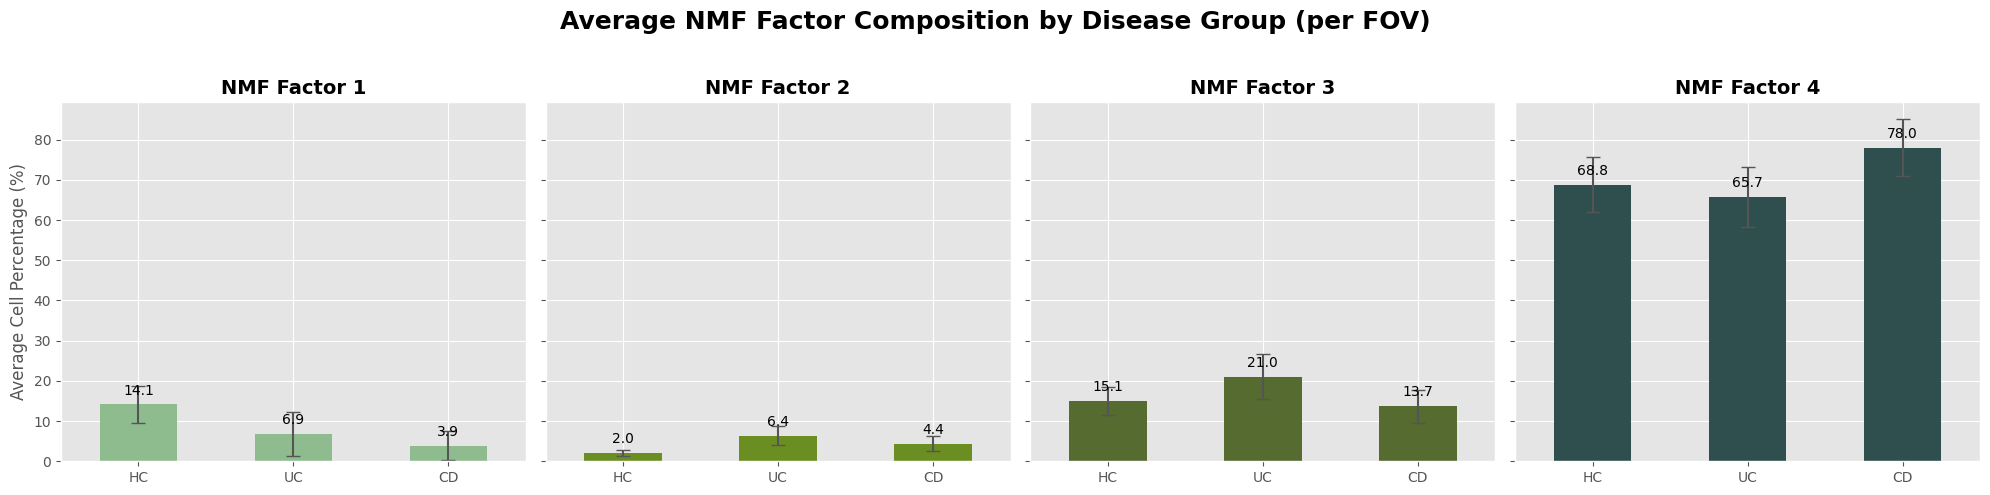

In [41]:
# Define file paths
h5ad_file = '/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/GSE234713_CosMx_annotated_with_celltype_and_nmf_factor.h5ad'
output_dir = '/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Analysis'
output_path = os.path.join(output_dir, 'nmf_factor_composition_by_disease_fov_avg.png')

# Load the AnnData object
adata = sc.read_h5ad(h5ad_file)

# --- 1. Data Preparation: Create a UNIQUE FOV identifier ---
# Extract disease group from 'unique_cell_id' (e.g., "CD")
adata.obs['disease_group'] = adata.obs['unique_cell_id'].str.split(' ').str[0]

# Combine disease_group and fov to create a unique FOV identifier
adata.obs['unique_fov'] = adata.obs['disease_group'].astype(str) + '_' + adata.obs['fov'].astype(str)

# --- 2. Calculate NMF Factor Composition per UNIQUE FOV ---
# Group by 'unique_fov' and 'NMF_factor' to get cell counts
composition_counts_fov = adata.obs.groupby(['unique_fov', 'NMF_factor']).size().unstack(fill_value=0)

# Normalize to get percentages for each unique FOV
composition_percentages_fov = composition_counts_fov.div(composition_counts_fov.sum(axis=1), axis=0) * 100

# --- 3. Calculate Average and Standard Deviation per Disease Group ---
# The index of 'composition_percentages_fov' is 'unique_fov'.
# We can extract the 'disease_group' directly from this index.
composition_percentages_fov['disease_group'] = composition_percentages_fov.index.str.split('_').str[0]

# Convert NMF factor columns to a numerical type for aggregation
numerical_cols = composition_percentages_fov.columns.drop('disease_group')
composition_percentages_fov[numerical_cols] = composition_percentages_fov[numerical_cols].astype(float)

# Calculate the mean and standard deviation, grouped by disease_group
avg_composition = composition_percentages_fov.groupby('disease_group')[numerical_cols].mean()
std_composition = composition_percentages_fov.groupby('disease_group')[numerical_cols].std()

# --- 4. Create the Multi-Panel Bar Graph ---
# Define the order of the bars
desired_order = ['HC', 'UC', 'CD']

# Re-index the dataframes to ensure the desired plotting order
avg_composition = avg_composition.reindex(desired_order)
std_composition = std_composition.reindex(desired_order)

# Define a list of colors (shades of green)
colors = ['#8FBC8F', '#6B8E23', '#556B2F', '#2F4F4F']

# Set up the figure with 4 subplots (1 for each NMF factor)
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

for i, ax in enumerate(axes):
    nmf_factor = i + 1
    
    # Extract the data for the current NMF factor
    avg_data = avg_composition[nmf_factor]
    std_data = std_composition[nmf_factor]
    
    # Plot the bar graph with error bars, using a specific color
    avg_data.plot(kind='bar', yerr=std_data, ax=ax, capsize=5, rot=0, color=colors[i])
    
    # Set titles and labels
    ax.set_title(f'NMF Factor {nmf_factor}', fontsize=14, fontweight='bold')
    ax.set_xlabel('')
    
    if i == 0:
        ax.set_ylabel('Average Cell Percentage (%)', fontsize=12)
    
    # Add data labels on top of the bars
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.1f}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', xytext=(0, 5), 
                    textcoords='offset points')

# Set a super title for the entire figure
fig.suptitle('Average NMF Factor Composition by Disease Group (per FOV)', fontsize=18, fontweight='bold')
fig.tight_layout(rect=[0, 0, 1, 0.95])

# --- 5. Save the plot ---
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

plt.savefig(output_path, dpi=600)
print(f"Bar graph of NMF factor composition saved to: {output_path}")

In [46]:
# Define file paths
h5ad_file = '/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/GSE234713_CosMx_annotated_with_celltype_and_nmf_factor.h5ad'
output_dir = '/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Analysis'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Load the AnnData object
adata = sc.read_h5ad(h5ad_file)

# --- 1. Data Preparation: Create a UNIQUE FOV identifier ---
# Extract disease group from 'unique_cell_id'
adata.obs['disease_group'] = adata.obs['unique_cell_id'].str.split(' ').str[0].str.upper()

# Combine disease_group and fov to create a unique FOV identifier
adata.obs['unique_fov'] = adata.obs['disease_group'].astype(str) + '_' + adata.obs['fov'].astype(str)

# Group by 'unique_fov' and 'NMF_factor' to get cell counts
composition_counts_fov = adata.obs.groupby(['unique_fov', 'NMF_factor']).size().unstack(fill_value=0)

# Normalize to get percentages for each unique FOV
composition_percentages_fov = composition_counts_fov.div(composition_counts_fov.sum(axis=1), axis=0) * 100

# Add 'disease_group' column from the index
composition_percentages_fov['disease_group'] = composition_percentages_fov.index.str.split('_').str[0]

# --- 2. Perform Statistical Tests and Store Results ---
all_results = []
significant_results = []
nmf_factors = [1, 2, 3, 4]
disease_groups = ['HC', 'UC', 'CD']

# Print the final counts for verification
print("Number of FOVs per disease group for statistical testing:")
print(composition_percentages_fov['disease_group'].value_counts())

for factor in nmf_factors:
    # Filter the DataFrame to include only the desired disease groups
    filtered_df = composition_percentages_fov[composition_percentages_fov['disease_group'].isin(disease_groups)].copy()
    
    # Check if all groups have at least 3 samples
    if not all(filtered_df[filtered_df['disease_group'] == group].shape[0] >= 3 for group in disease_groups):
        print(f"Skipping NMF Factor {factor} due to insufficient samples per group.")
        continue

    # Perform Dunn's post-hoc test for pairwise comparisons
    try:
        posthoc_results = posthoc_dunn(filtered_df, val_col=factor, group_col='disease_group', p_adjust='fdr_bh')
        
        # Reformat results for easier interpretation
        for group1 in disease_groups:
            for group2 in disease_groups:
                if group1 < group2:
                    p_value = posthoc_results.loc[group1, group2]
                    
                    # Get the mean percentages for the groups
                    mean1 = filtered_df[filtered_df['disease_group'] == group1][factor].mean()
                    mean2 = filtered_df[filtered_df['disease_group'] == group2][factor].mean()
                    
                    difference = mean1 - mean2
                    direction = 'Up' if difference > 0 else 'Down'

                    is_significant = 'Yes' if p_value < 0.05 else 'No'

                    result_row = {
                        'NMF factor': factor,
                        'group 1': group1,
                        'group 2': group2,
                        'difference between means': difference,
                        'direction (up is group 1 > group 2)': direction,
                        'p-value': p_value,
                        'significant?': is_significant
                    }
                    
                    all_results.append(result_row)
                    if is_significant == 'Yes':
                        significant_results.append(result_row)
    except Exception as e:
        print(f"Error during posthoc test for NMF Factor {factor}: {e}")
        continue


# --- 3. Save Results to CSV Files ---
all_results_df = pd.DataFrame(all_results)
all_results_df.to_csv(os.path.join(output_dir, 'all_nmf_factor_comparisons.csv'), index=False)

significant_results_df = pd.DataFrame(significant_results)
significant_results_df.to_csv(os.path.join(output_dir, 'significant_nmf_factor_comparisons.csv'), index=False)

print(f"\nStatistical comparison results saved to: {output_dir}")
print(f"Saved {len(all_results)} total comparisons and {len(significant_results)} significant comparisons.")

Number of FOVs per disease group for statistical testing:
disease_group
UC    24
CD    20
HC    20
Name: count, dtype: int64

Statistical comparison results saved to: /blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Analysis
Saved 12 total comparisons and 9 significant comparisons.


* Up: The mean percentage of the NMF factor in Group 1 is higher than in Group 2.
* Down: The mean percentage of the NMF factor in Group 1 is lower than in Group 2.

The code calculates this by comparing mean1 (Group 1) and mean2 (Group 2). If mean1 - mean2 is a positive number, the direction is "Up". If it's a negative number, the direction is "Down". This provides a quick summary of which group has a greater composition of a particular NMF factor.

In [47]:
# Define file paths
h5ad_file = '/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/GSE234713_CosMx_annotated_with_celltype_and_nmf_factor.h5ad'
output_dir = '/blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Analysis'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Load the AnnData object
adata = sc.read_h5ad(h5ad_file)

# --- 1. Data Preparation: Calculate FOV-level proportions ---
# Extract disease group from 'unique_cell_id'
adata.obs['disease_group'] = adata.obs['unique_cell_id'].str.split(' ').str[0].str.upper()

# Combine disease_group and fov to create a unique FOV identifier
adata.obs['unique_fov'] = adata.obs['disease_group'].astype(str) + '_' + adata.obs['fov'].astype(str)

# Group by 'unique_fov' and 'PredictedCellType' to get cell counts
composition_counts_fov = adata.obs.groupby(['unique_fov', 'PredictedCellType']).size().unstack(fill_value=0)

# Normalize to get percentages for each unique FOV
composition_percentages_fov = composition_counts_fov.div(composition_counts_fov.sum(axis=1), axis=0) * 100

# Add 'disease_group' column from the index
composition_percentages_fov['disease_group'] = composition_percentages_fov.index.str.split('_').str[0]

# --- 2. Perform Statistical Tests and Store Results ---
all_results = []
significant_results = []
disease_groups = ['HC', 'UC', 'CD']

# Get the list of unique cell types from the data
predicted_cell_types = list(composition_percentages_fov.columns.drop('disease_group'))
# For each PredictedCellType, filter the data and perform the test
for cell_type in predicted_cell_types:
    # Filter the DataFrame to include only the desired disease groups
    filtered_df = composition_percentages_fov[composition_percentages_fov['disease_group'].isin(disease_groups)].copy()

    # Check if all groups have at least 3 samples
    if not all(filtered_df[filtered_df['disease_group'] == group].shape[0] >= 3 for group in disease_groups):
        print(f"Skipping PredictedCellType {cell_type} due to insufficient samples per group.")
        continue

    # Perform Dunn's post-hoc test for pairwise comparisons
    try:
        posthoc_results = posthoc_dunn(filtered_df, val_col=cell_type, group_col='disease_group', p_adjust='fdr_bh')
        
        # Reformat results for easier interpretation
        for group1 in disease_groups:
            for group2 in disease_groups:
                if group1 < group2:
                    p_value = posthoc_results.loc[group1, group2]
                    
                    # Get the mean percentages for the groups
                    mean1 = filtered_df[filtered_df['disease_group'] == group1][cell_type].mean()
                    mean2 = filtered_df[filtered_df['disease_group'] == group2][cell_type].mean()
                    
                    difference = mean1 - mean2
                    direction = 'Up' if difference > 0 else 'Down'

                    is_significant = 'Yes' if p_value < 0.05 else 'No'

                    result_row = {
                        'PredictedCellType': cell_type,
                        'group 1': group1,
                        'group 2': group2,
                        'difference between means': difference,
                        'direction (up is group 1 > group 2)': direction,
                        'p-value': p_value,
                        'significant?': is_significant
                    }
                    
                    all_results.append(result_row)
                    if is_significant == 'Yes':
                        significant_results.append(result_row)
    except Exception as e:
        print(f"Error during posthoc test for PredictedCellType {cell_type}: {e}")
        continue


# --- 3. Save Results to CSV Files ---
all_results_df = pd.DataFrame(all_results)
all_results_df.to_csv(os.path.join(output_dir, 'all_cell_type_comparisons.csv'), index=False)

significant_results_df = pd.DataFrame(significant_results)
significant_results_df.to_csv(os.path.join(output_dir, 'significant_cell_type_comparisons.csv'), index=False)

print(f"\nStatistical comparison results saved to: {output_dir}")
print(f"Saved {len(all_results)} total comparisons and {len(significant_results)} significant comparisons.")

/scratch/local/10013196/ipykernel_1976361/3232082641.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  composition_counts_fov = adata.obs.groupby(['unique_fov', 'PredictedCellType']).size().unstack(fill_value=0)



Statistical comparison results saved to: /blue/pbenos/tan.m/IBDCosMx_scRNAseq/CosMx/Analysis
Saved 162 total comparisons and 111 significant comparisons.
